In [1]:
import numpy as np
import random
#import itertools as it
import time
import matplotlib.pyplot as plt

In [2]:
# Function for returning the state and index in list of neighbors of an empty cell.
def choose_neighbor(neighborhood, cell_coord): 
        i = cell_coord[0]
        j = cell_coord[1]
        k = cell_coord[2]
        
        neighbor_i = None
        neighbor_j = None
        neighbor_k = None
        
        possible_neighbor_coords = [[n_i,n_j,n_k] for n_i in [i+1,i-1,i] 
                                    for n_j in [j+1,j-1,j] for n_k in [k+1,k-1,k]]
        possible_neighbor_coords.remove(cell_coord)
        random.shuffle(possible_neighbor_coords)
        for n_coord in possible_neighbor_coords:
            n_i = n_coord[0]
            n_j = n_coord[1]
            n_k = n_coord[2]
            
            if neighborhood[n_i,n_j,n_k] == EMPTY:# and n_coord != cell_coord:
                neighbor_i = n_i
                neighbor_j = n_j
                neighbor_k = n_k
        
        return neighbor_i, neighbor_j, neighbor_k

def get_empty_neighbor(neighbors): 
        idx = 10**4
        idxs = list(range(len(neighbors)))
        random.shuffle(idxs)

        for i in idxs:
            if neighbors[i] == EMPTY:
                idx = i
                break
                
        return idx



In [3]:
# These should return new_neighbor_state and new_cell_state

def die(last_cell_state, P_die):
    if last_cell_state != (DEAD or EMPTY or CSC):
        rand = random.random()
        if rand <= P_die:
            new_cell_state = DEAD
        else:
            new_cell_state = last_cell_state
        return new_cell_state
        
def divide(last_cell_state, P_divide, P_asym):
    rand = random.random()
    if rand <= P_divide and last_cell_state != (DEAD or EMPTY):
        if last_cell_state == CSC:
            rand = random.random()
            if rand <= P_asym: # asymmetric cell division
                new_neighbor_state = nCSC_10
                new_cell_state = CSC
            else: # symmetric cell division
                new_neighbor_state = CSC
                new_cell_state = CSC
    
        else: # non-CSCs must division symmetrically
            new_neighbor_state = nCSC_10
            new_cell_state = last_cell_state - 1 # decrease the proliferative potential down to 1.    
        return new_cell_state, new_neighbor_state
    else:
        return False, False
    
def migrate(last_cell_state, P_migrate):
    rand = random.random()
    if rand <= P_migrate and last_cell_state != (DEAD or EMPTY):
        new_neighbor_state = last_cell_state
        new_cell_state = EMPTY
    else:
        new_cell_state = last_cell_state
        new_neighbor_state = EMPTY
    return new_cell_state, new_neighbor_state

In [4]:
# Function for the actions of one cell, 
# returns new state of the cell and the new state of a neighbor    
# last_cell_state is either CSC or nonCSC
def evolve_cell(last_cell_state, coord, P_die, P_divide, P_asym, P_migrate):
    new_cell_state = last_cell_state
    new_neighbor_state = EMPTY
    
    # Apoptosis
    if last_cell_state != CSC:
        new_cell_state = die(last_cell_state, P_die)
        #rand = random.random()
        #if last_cell_state != CSC and rand <= P_die:
         #   new_cell_state = DEAD
            
    if new_cell_state == last_cell_state:            
        # choose neighbor
        neighbor_i, neighbor_j, neighbor_k = choose_neighbor(neighborhood, coord)
        if neighbor_i != None:
            # Migration or Division   
            new_cell_state, new_neighbor_state = divide(last_cell_state, P_divide, P_asym)
            if (new_cell_state, new_neighbor_state) == (False,False):
                new_cell_state, new_neighbor_state = migrate(last_cell_state, P_migrate)
                
        # Update neighbor    
        neighborhood[neighbor_i, neighbor_j, neighbor_k] = new_neighbor_state 
            
    # Update cell
    i = coord[0]
    j = coord[1]
    k = coord[2]
    neighborhood[i,j,k] = new_cell_state
            
    return neighborhood#new_cell_state, new_neighbor_state   

In [5]:
# Function for one interation of updating through all cells
# Returns updated neighborhood

def update_step_rand_ordering(neighborhood, size_h, size_w, size_d):
    # Loop through each cell in random order and find its neighbors
    #coords = list(it.product(range(size),repeat=3))
    coords = [[i,j,k] for i in range(size_h) for j in range(size_w) for k in range(size_d)]
    random.shuffle(coords)
    for coord in coords:
        i = coord[0]
        j = coord[1]
        k = coord[2]
        cell = neighborhood[i,j,k]
        if (i<=size_h-2 and j<=size_w-2 and k<=size_d-2) and cell!=EMPTY:
                        
            # Pick an empty neighbor
            #idx_in_neighbors = get_empty_neighbor(neighbors)
            #if idx_in_neighbors != 10**4:
                #print('found empty neighbor')
            #neighbor_i, neighbor_j, neighbor_k = choose_neighbor(neighborhood, coord)
            #if neighbor_i != 10**10:
                
            # Clear dead cell
            if cell == DEAD:
                neighborhood[i,j,k] = EMPTY
                
            # Evolve cell
            if cell != DEAD and cell != EMPTY:
                neighborhood = evolve_cell(cell, coord, P_die, P_divide, P_asym, P_migrate)
        
    return neighborhood

In [6]:
# Function for expanding the neighborhood
def expand_neighborhood(neighborhood, size_h, size_w, size_d, delta_size):
    # Surfaces
    left = neighborhood[:,0,:] 
    front = neighborhood[:,:,0]
    top = neighborhood[0,:,:]
    right = neighborhood[:,-1,:]
    back = neighborhood[:,:,-1]
    bottom = neighborhood[-1,:,:]
        
    #if left.any()!=EMPTY or front.any()!=EMPTY or top.any()!=EMPTY or right.any()!=EMPTY or back.any()!=EMPTY or bottom.any()!=EMPTY:
     #   size += delta_size
      #  neighborhood.resize((size,size,size), refcheck=False)
       # print(f'new size: {size}')
        
    if left.any()!=EMPTY:
        size_w += delta_size
        neighborhood = np.concatenate([np.zeros((size_h, delta_size, size_d)), neighborhood], axis=1)
        #print(f'new size: ({size_h,size_w,size_d})')
    
    if front.any()!=EMPTY:
        size_d += delta_size
        neighborhood = np.concatenate([np.zeros((size_h, size_w, delta_size)), neighborhood], axis=2)
        #print(f'new size: ({size_h,size_w,size_d})')
        
    if top.any()!=EMPTY:
        size_h += delta_size
        neighborhood = np.concatenate([np.zeros((delta_size, size_w, size_d)), neighborhood], axis=0)
        #print(f'new size: ({size_h,size_w,size_d})')
        
    if right.any()!=EMPTY:
        size_w += delta_size
        neighborhood = np.concatenate([neighborhood, np.zeros((size_h, delta_size, size_d))], axis=1)
        #print(f'new size: ({size_h,size_w,size_d})')
        
    if back.any()!=EMPTY:
        size_d += delta_size
        neighborhood = np.concatenate([neighborhood, np.zeros((size_h, size_w, delta_size))], axis=2)
        #print(f'new size: ({size_h,size_w,size_d})')
        
    if bottom.any()!=EMPTY:
        size_h += delta_size
        neighborhood = np.concatenate([neighborhood, np.zeros((delta_size, size_w, size_d))], axis=0)
        #print(f'new size: ({size_h,size_w,size_d})')
    
    print(f'new size: ({size_h,size_w,size_d})')
    return neighborhood, size_h, size_w, size_d

In [ ]:
# States and Parameters
CSC = 12 #11
nCSC_10 = 11 #10
nCSC_9 = 10
nCSC_8 = 9
nCSC_7 = 8
nCSC_6 = 7
nCSC_5 = 6
nCSC_4 = 5
nCSC_3 = 4
nCSC_2 = 3
nCSC_1 = 2
DEAD = 1 #0
EMPTY = 0 #12

P_die = 0.01
P_divide = 1/24 # 1 cell cycle in 24 hours (steps)
P_migrate = (1-P_divide)*10/24 # 10 spaces in 24 hours (steps)
P_asym = 0.9 # probability of asymmetric cell division for cancer stem cells
size_h = 10 # height
size_w = 10 # width
size_d = 10 # depth
steps = 1000 # hours
delta_size = 5 # amount to add to growing array
check_surface_interval = 50 # amount of steps to wait before growing array, 50?
reporting_interval = 100

# Set up the neighborhood
neighborhood = np.full((size_h,size_w,size_d), EMPTY)
neighborhood[(int(size_h/2),int(size_w/2),int(size_d/2))] = CSC

num_CSC = [sum(np.ravel(neighborhood) == CSC)]
num_DEAD = [sum(np.ravel(neighborhood) == DEAD)]
num_EMPTY = [sum(np.ravel(neighborhood) == EMPTY)]
num_nCSC = [(size_h*size_w*size_d) - num_CSC[0] - num_DEAD[0] - num_EMPTY[0]]
num_total = num_CSC + num_nCSC + num_DEAD + num_EMPTY
num_nEMPTY = num_CSC + num_nCSC + num_DEAD

tic = time.perf_counter() 
for i in range(steps):
    # Update
    neighborhood = update_step_rand_ordering(neighborhood, size_h, size_w, size_d)
    new_CSC = sum(neighborhood.reshape(-1) == CSC)
    new_DEAD = sum(neighborhood.reshape(-1) == DEAD)
    new_EMPTY = sum(neighborhood.reshape(-1) == EMPTY)
    new_nCSC = (size_h*size_w*size_d) - new_CSC - new_DEAD - new_EMPTY
    num_CSC.append(new_CSC)
    num_DEAD.append(new_DEAD)
    num_EMPTY.append(new_EMPTY)
    num_nCSC.append(new_nCSC)
    num_nEMPTY.append(new_CSC + new_DEAD + new_nCSC)
    num_total.append(new_CSC + new_DEAD + new_EMPTY + new_nCSC)
    
    # Report
    if i!=0 and i%reporting_interval == 0:
        print(f'Completed {i}th step')
        print(f'Cancer Stem Cells: {new_CSC}, Dead Cells: {new_DEAD}, Empty Cells: {new_EMPTY}, Cancer Non-Stem Cells: {new_nCSC}')
        
    # Expand if needed
    if i!=0 and i%check_surface_interval == 0:
        neighborhood, size_h, size_w, size_d = expand_neighborhood(neighborhood, size_h, size_w, size_d, delta_size)
toc = time.perf_counter() 
print(f'Time to finish {steps} steps: {toc-tic}')

final_CSC = sum(neighborhood.reshape(-1) == CSC)
final_DEAD = sum(neighborhood.reshape(-1) == DEAD)
final_EMPTY = sum(neighborhood.reshape(-1) == EMPTY)
final_nCSC = (size_h*size_w*size_d) - final_CSC - final_DEAD - final_EMPTY

print(f'Final Cancer Stem Cells: {final_CSC}, Final Dead Cells: {final_DEAD}, Final Empty Cells: {final_EMPTY}, Final Cancer Non-Stem Cells: {final_nCSC}')



In [ ]:
np.save('neighborhood_arrays_1000_8.npy', neighborhood)
np.save('CSC_counts_arrays_1000_8.npy', num_CSC)
np.save('nCSC_counts_arrays_1000_8.npy', num_nCSC)
np.save('DEAD_counts_arrays_1000_8.npy', num_DEAD)
np.save('EMPTY_counts_arrays_1000_8.npy', num_EMPTY)
np.save('Total_counts_arrays_1000_8.npy', num_total)
np.save('nEMPTY_counts_arrays_1000_8.npy', num_nEMPTY)

In [ ]:
# plot populations
fig = plt.figure(figsize=(8, 5))
plt.plot(num_nCSC, c='b', label='Cancer Non-Stem Cell')
plt.plot(num_CSC, c='r', label='Cancer Stem Cell')
plt.plot(num_DEAD, c='k', label='Dead Cell')
plt.legend()
plt.title('Array: Cell Populations')
plt.xlabel('Time (steps)')
plt.ylabel('Number of Cells')
plt.savefig('array_sim_8.jpg')
    
fig = plt.figure(figsize=(8, 5))
plt.plot(num_CSC, c='r', label='Cancer Stem Cell')
plt.plot(num_DEAD, c='k', label='Dead Cell')
plt.legend()
plt.title('Array: Stem Cells and Dead Cells')
plt.xlabel('Time (steps)')
plt.ylabel('Number of Cells')
plt.savefig('array_sim_8_justCSCDEAD.jpg')
    
fig = plt.figure(figsize=(8, 5))
plt.plot(num_total, c='r', label='All Cells (including EMPTY)')
plt.plot(num_EMPTY, c='b', label='Empty Cells')
plt.plot(num_nEMPTY, c='k', label='Occupied Cells')
plt.plot([1/j for i,j in zip(num_nEMPTY,num_total)] , c='g', label='Proportion of Occupied/Total')
plt.legend()
plt.title('Array: Filling of Allocated Spaces')
plt.xlabel('Time (steps)')
plt.ylabel('Number of Cells')
plt.savefig('array_sim_8_fullpop.jpg')

In [7]:
num_CSC = np.load('CSC_counts_arrays_300_6.npy')
num_nCSC = np.load('nCSC_counts_arrays_300_6.npy')
num_DEAD = np.load('DEAD_counts_arrays_300_6.npy')
num_Occ = np.load('nEMPTY_counts_arrays_300_6.npy')

In [16]:
print(num_Occ.shape)
print(log_Occ.shape)
print(len(range(250)))
print(log_nCSC[-1]/250)

(253,)
(253,)
250
0.028899013623071883


C:\Users\mzb56\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\mzb56\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mzb56\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


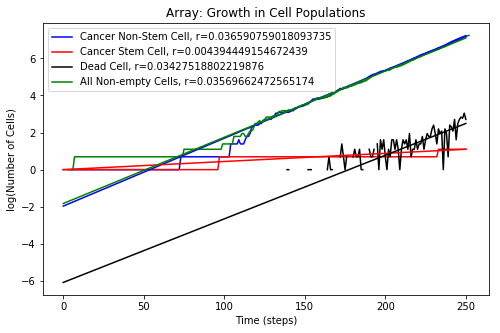

In [20]:
log_CSC = np.log(num_CSC)
log_nCSC = np.log(num_nCSC)
log_DEAD = np.log(num_DEAD)
log_Occ = np.log(num_Occ)

x = range(251)
# y = the logs
slope_CSC = (log_CSC[-1])/250
intercept_CSC = 0
#slope_nCSC = (log_nCSC[-1])/250
#intercept_nCSC = 0
slope_DEAD = (log_DEAD[-1]/250)
intercept_DEAD = 0
#slope_Occ = (log_Occ[-1]/250)
#intercept_Occ = 0

#slope_CSC, intercept_CSC = np.polyfit(x, log_CSC, 1)
slope_nCSC, intercept_nCSC = np.polyfit(x[125:], log_nCSC[125:], 1)
slope_DEAD, intercept_DEAD = np.polyfit(x[200:], log_DEAD[200:], 1)
slope_Occ, intercept_Occ = np.polyfit(range(253)[125:], log_Occ[125:], 1)

fig = plt.figure(figsize=(8, 5))
# plot the logs
plt.plot(log_nCSC, c='b', label=f'Cancer Non-Stem Cell, r={slope_nCSC}')
plt.plot(log_CSC, c='r', label=f'Cancer Stem Cell, r={slope_CSC}')
plt.plot(log_DEAD, c='k', label=f'Dead Cell, r={slope_DEAD}')
plt.plot(log_Occ, c='g', label=f'All Non-empty Cells, r={slope_Occ}')

# plot the lines
plt.plot(x, slope_nCSC*x + intercept_nCSC, c='b')
plt.plot(x, slope_CSC*x + intercept_CSC, c='r')
plt.plot(x, slope_DEAD*x + intercept_DEAD, c='k')
plt.plot(x, slope_Occ*x + intercept_Occ, c='g')
    
plt.legend()
plt.title('Array: Growth in Cell Populations')
plt.xlabel('Time (steps)')
plt.ylabel('log(Number of Cells)')
plt.savefig('array_log_4.jpg')

In [9]:
import sys
sys.getsizeof(True)

28

In [8]:
sys.getsizeof('c')

50

In [12]:
sys.getsizeof(0)

24

In [2]:
a = np.zeros((100,100,100))

tic = time.perf_counter() 
np.ravel(a)
toc = time.perf_counter() 
print(f'ravel: {toc-tic}')

tic = time.perf_counter() 
a.flatten()
toc = time.perf_counter()
print(f'flatten: {toc-tic}')

tic = time.perf_counter() 
a.reshape(-1)
toc = time.perf_counter()
print(f'reshape: {toc-tic}')

ravel: 0.00038819999999972765
flatten: 0.03346859999999907
reshape: 0.00031729999999896563


In [6]:
i = 0
j = 0
k = 0

tic = time.perf_counter()
coords = list(it.product(range(100),repeat=3))
random.shuffle(coords)
for coord in coords:
    i = coord[0]
    j = coord[1]
    k = coord[2]
toc = time.perf_counter()
print(f'it.product: {toc-tic}')

tic = time.perf_counter()
coords = [(i,j,k) for i in range(100) for j in range(100) for k in range(100)]
random.shuffle(coords)
for coord in coords:
    i = coord[0]
    j = coord[1]
    k = coord[2]
toc = time.perf_counter()
print(f'nested fors: {toc-tic}')

#consider using nested fors...

it.product: 6.405409999999961
nested fors: 5.980575699999974


In [7]:
i = 0
j = 0
k = 0

tic = time.perf_counter()
coords = list(it.product(range(10),repeat=3))
random.shuffle(coords)
for coord in coords:
    i = coord[0]
    j = coord[1]
    k = coord[2]
toc = time.perf_counter()
print(f'it.product: {toc-tic}')

tic = time.perf_counter()
coords = [(i,j,k) for i in range(10) for j in range(10) for k in range(10)]
random.shuffle(coords)
for coord in coords:
    i = coord[0]
    j = coord[1]
    k = coord[2]
toc = time.perf_counter()
print(f'nested fors: {toc-tic}')

it.product: 0.44317329999995536
nested fors: 0.013997900000049412


In [18]:
b = np.zeros((3,3,3))

In [19]:
tic = time.perf_counter()
a = np.concatenate([b,np.ones((3,3,3))], axis=0)
toc = time.perf_counter()
print(f'concatenate: {toc-tic}')

tic = time.perf_counter()
a = np.vstack([b,np.ones((3,3,3))])
toc = time.perf_counter()
print(f'stack: {toc-tic}')

concatenate: 0.00032349999992220546
stack: 0.00032659999988027266


In [16]:
a.shape

(3, 6, 3)

In [20]:
b = np.zeros((3,3,3))
a = np.concatenate([b,np.ones((3,3,3))], axis=0)
a.shape

(6, 3, 3)

In [8]:
# cost of checking
a=np.zeros((3,3,3))
tic = time.perf_counter()
left = a[:,0,:] 
if left.any()!=1:
    print('not one')
toc = time.perf_counter()
print(f'checking surface: {toc-tic}')

not one
checking surface: 0.0027239000000918168
